# MODULE CONTROL WORK (Homework)

In this homework you are going to use the Harris corner detector to detect the corners of a document. Document detection is a crucial task for many applications, e.g., text recognition, automatic passport reading (at airport gates), etc.

You will also have to design your own feature descriptor in order to localize and distinguish among the 4 document corners.

At the end of this notebook, there are a couple of questions for you to answer.

So let's begin, shall we?

In [32]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image we will be working on in this homework.

(<Axes: >, <matplotlib.image.AxesImage at 0x16e18463c50>)

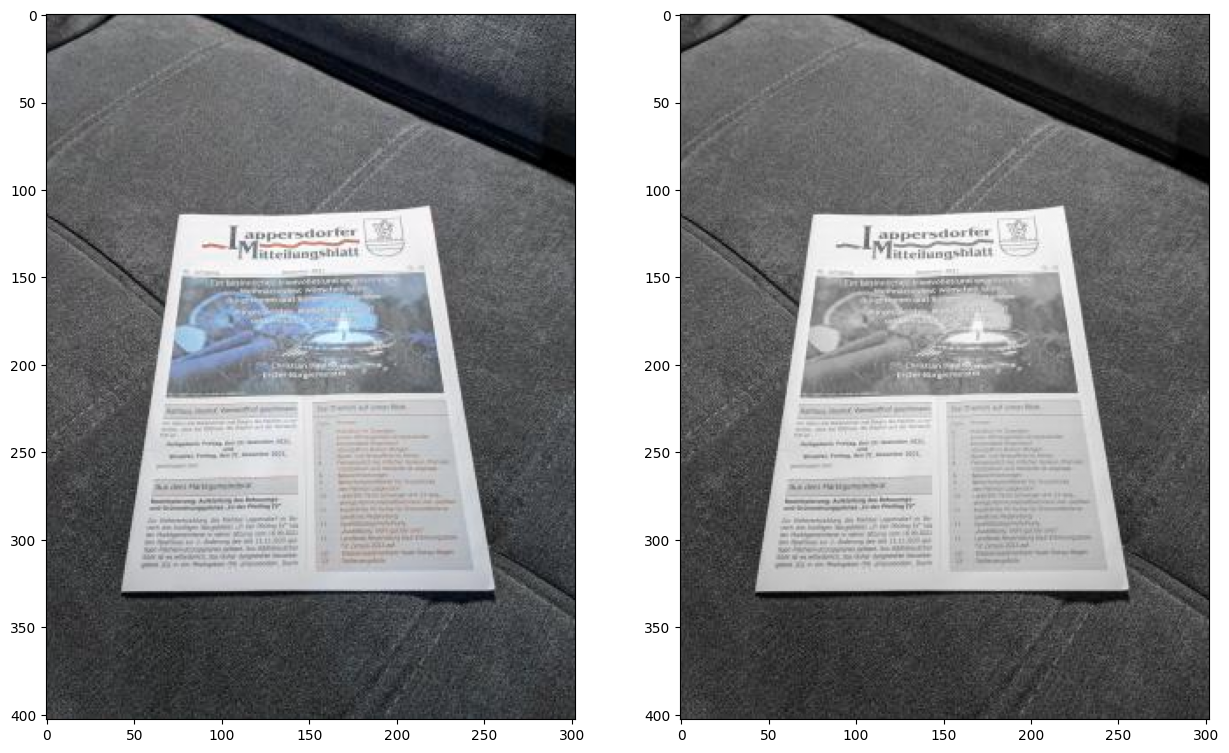

In [33]:
# Let's read the image
img = cv2.imread('data/document.jpg')
# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

### Harris Corner Detector
Let us now compute Harris corners. Remember that the Harris detector computes the "cornerness" score for each image pixel.

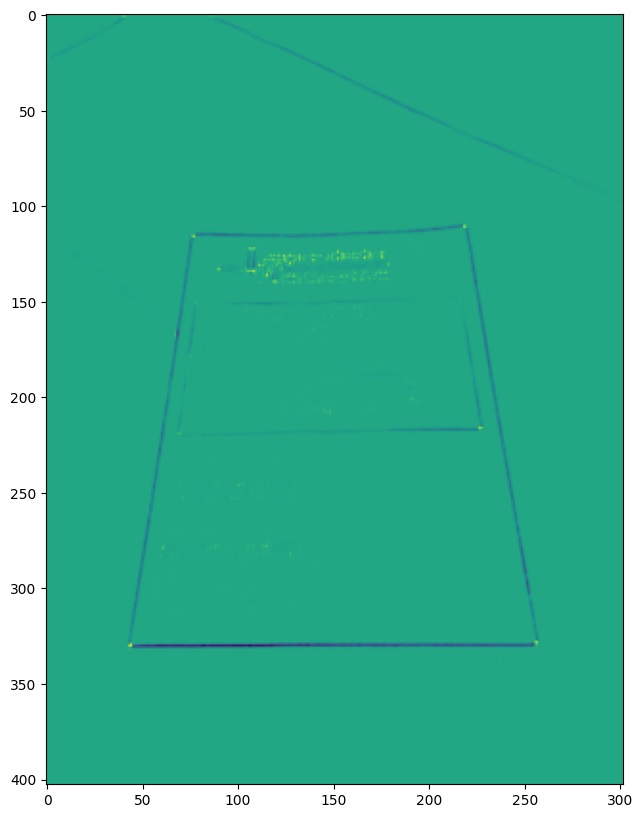

In [34]:
# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04
cornerness = cv2.cornerHarris(gray, 2, 3, 0.04)
plt.imshow(cornerness)

In [35]:

# We are not interested in edges, so put to zero all negative cornerness values
cornerness = np.where(cornerness < 0, 0, cornerness)

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)

(<Axes: >,
 <matplotlib.colorbar.Colorbar at 0x16e19570f50>)

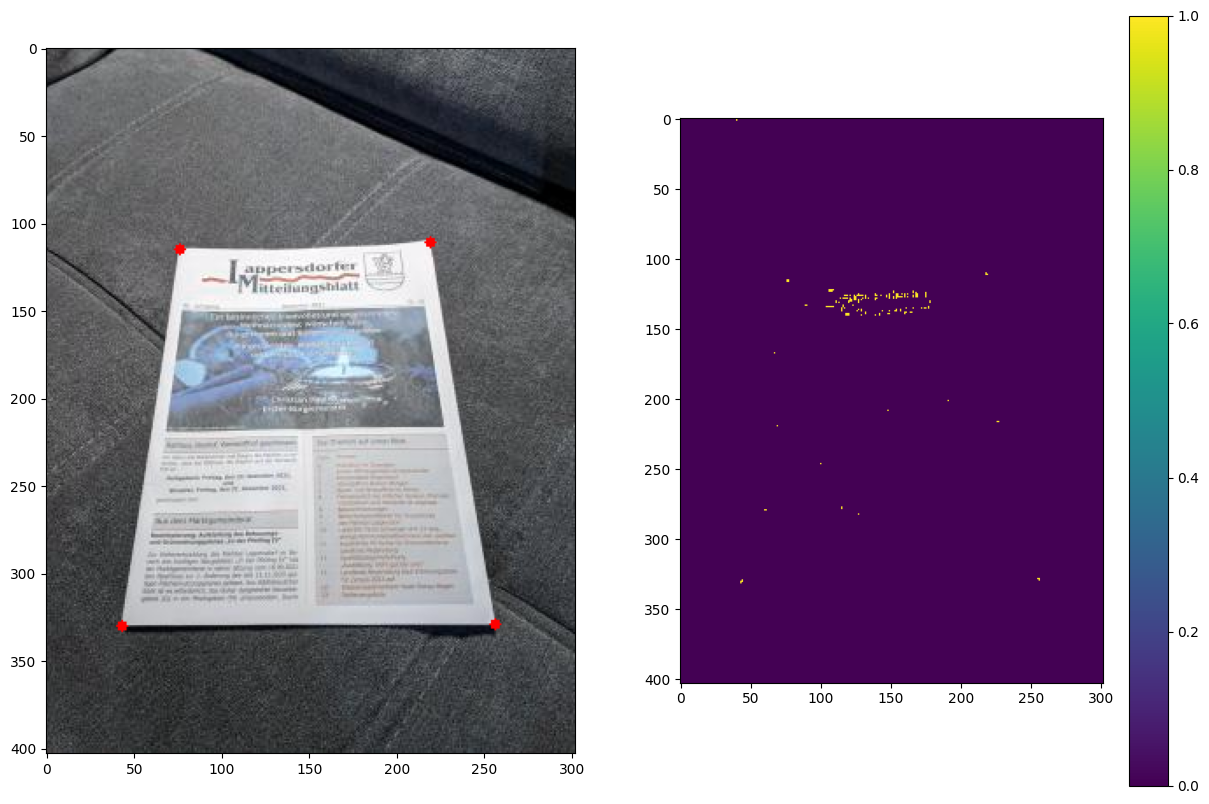

In [38]:
# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness>-7), plt.colorbar()

At this point, you can see that the Harris detector has detected a lot of features. Not only the four document corners, but also the corners corresponding to (black) letters printed on (white) paper. How can we filter out everything but the 4 document corners?

For that purpose, let's design a custom feature descriptor suitable to detect the document corners. In order to do so, let's have a look at the top left corner.

![Top-left corner](../data/document_descriptor_example.jpg "Top-left corner")

A good descriptor of that corner, given a certain neghbouring region, would be to assess that the bottom-right quadrant is (much) brighter than the other three quadrants (i.e. top-left, top-right, bottom-left). Let's then implement it :-) I'll do the implementation for the top-left corner, you shall do the rest.

(<Axes: >, <matplotlib.image.AxesImage at 0x16e1507e350>)

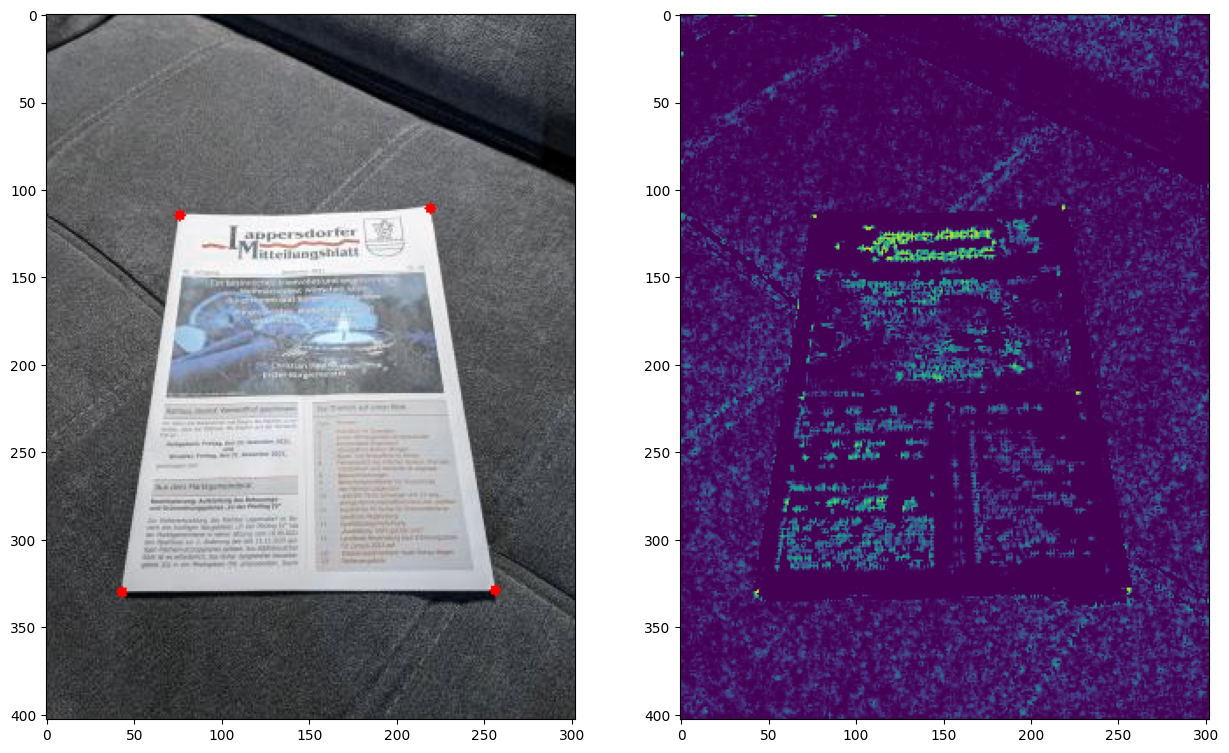

In [37]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue

        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]

        # Extract the four quandrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size+1:]
        quad_bottom_left = block[quad_size+1:, 0:quad_size]
        quad_bottom_right = block[quad_size+1:, quad_size+1:]
 
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)

        # Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
             (np.mean(quad_top_left) + np.mean(quad_top_right) + np.mean(quad_bottom_right))
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)

        # Bottom-left corner
        descriptor = np.mean(quad_top_right) - \
             (np.mean(quad_bottom_left) + np.mean(quad_top_left) + np.mean(quad_bottom_right))

        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)

        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
             (np.mean(quad_bottom_right) + np.mean(quad_bottom_left) + np.mean(quad_top_right))
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_right, 3, (255,0,0), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)

### Questions
* Does it matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera? How?
* If we increased the resolution of the camera, what would you change in the current algorithm?

Remember, I am **not** looking for a particular answer. I want to see how you think, so be creative ;-)

1. Yes, it does. The difference is how much of the physical world is represented by fixed 15×15 pixel detection window (quad_size=7).  
At 12 Mpx, the algorithm zooms in too close, losing the essential global contrast information necessary to find the corner.   
2. Replace harcoded quad_size = 7 with something like max(7,round(k⋅min(rows,cols))), k = 0.01.  
The fixed Harris threshold **cornerness [r, c]<−7** will be overwhelmed by hundreds of micro-noise corners at 12 Mpx => select only the top-N strongest, clearest peaks (e.g., the top 100 points globally).   
By choosing only the most dominant candidates, we ignore the weak, noisy points generated by the high-resolution image


